# Pix2Pix GAN (style-based Pix2Pix GAN to be implemented)

**Materials:**

- [Machine Learning Mastery](https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/)

In [6]:
# fix imports
from fix_imports import fix_relative_imports
fix_relative_imports()

In [1]:
from keras.utils import plot_model

### Discriminator: PatchGAN 

Visualize and use model

/Users/guilhermeleonardonunes/temp/computer-vision/implementations/.venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         6208      ['concatenate[0][0]']     

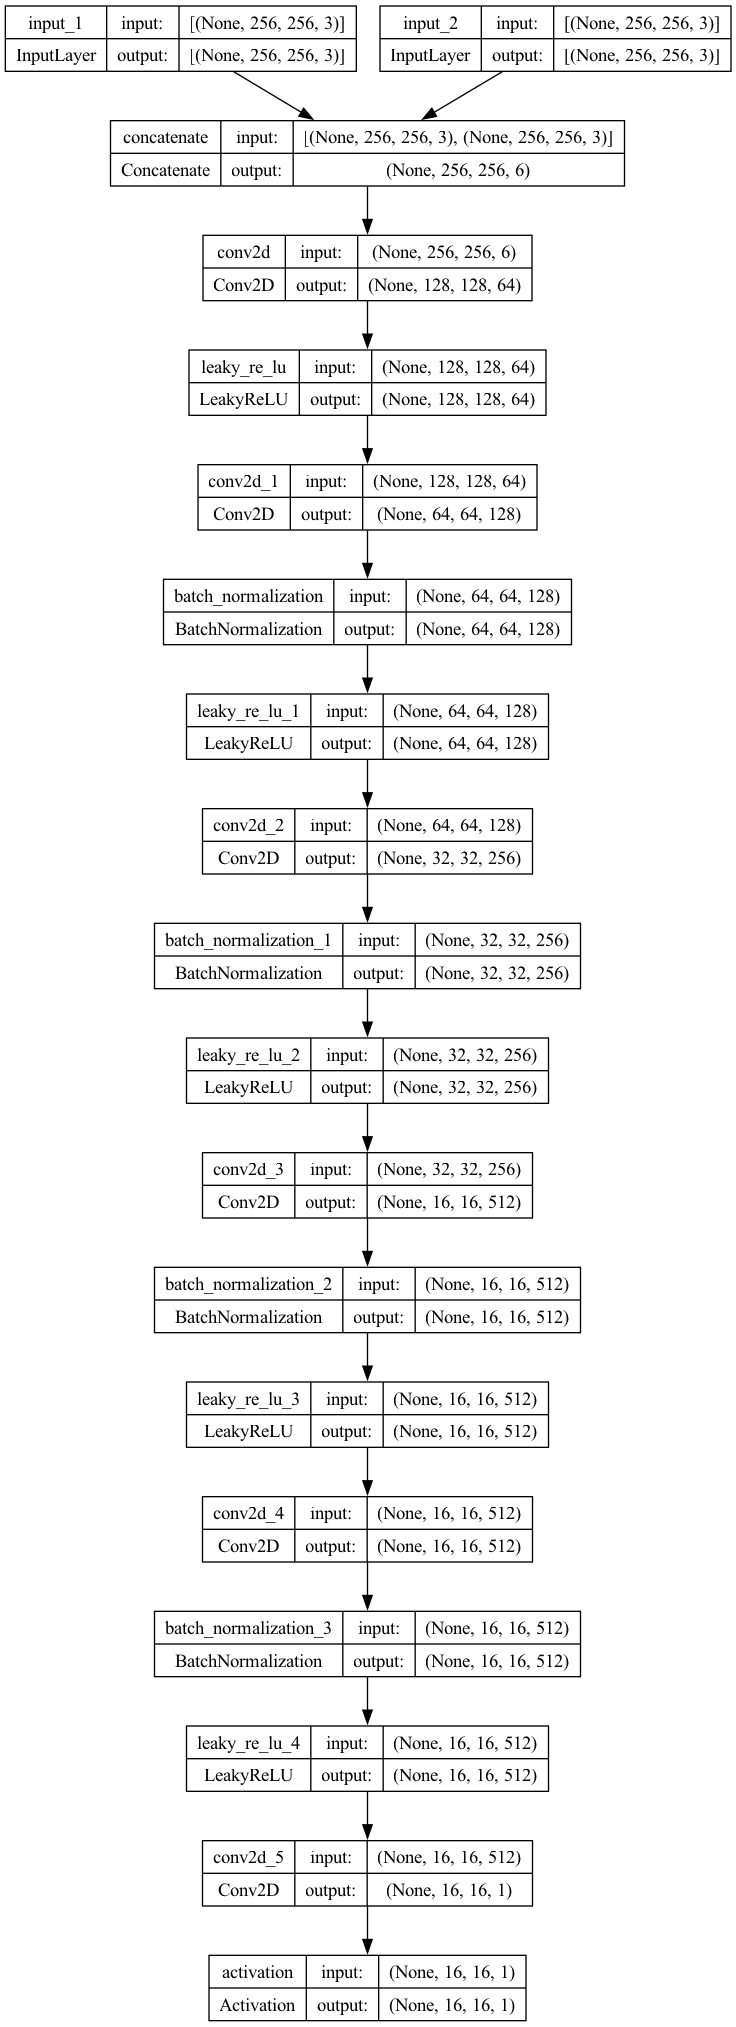

In [5]:
from pix2pix_gan.discriminator import create_discriminator

image_shape = (256,256,3)
model = create_discriminator(image_shape)
model.summary()
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)


### Generator: U-Net

In [ ]:
from pix2pix_gan.generator import create_generator

image_shape = (256,256,3)
model = create_generator(image_shape)
model.summary()
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)